In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt # For making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [7]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [153]:
#Build the dataset: Train, Dev, and Test
block_size = 3 #context length: How many characters needed to predict the next

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[:n2]) #Last 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([205320, 3]) torch.Size([205320])


In [154]:
n_embd * block_size

30

In [155]:
#MLP revisited, no more magic numbers for the model
n_embd = 10 #The dimensionality of the character embedding vector
n_hidden = 200 #The Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3) / ((n_embd * block_size) ** 0.5))
# Gain / Fan in = 5/3 for Tanh divided by square root of fan in,
# which is n_embd * block_size
# More from https://pytorch.org/docs/stable/nn.init.html
# b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 
# Never use a 0 for the weights
b2 = torch.randn(vocab_size, generator=g) * 0 

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# Created to track the running values, not for gradient optomization
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True


12297


tensor(-0.0074) tensor(0.9980)
tensor(0.0019) tensor(1.0065)


(array([2.23283295e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.23283295e-05, 4.46566590e-05, 0.00000000e+00, 0.00000000e+00,
        2.00954966e-04, 1.56298307e-04, 4.24238261e-04, 9.82446499e-04,
        1.80859469e-03, 3.14829446e-03, 5.51509739e-03, 9.37789840e-03,
        1.59870839e-02, 2.62134589e-02, 3.86726667e-02, 6.29435609e-02,
        9.18364193e-02, 1.31335234e-01, 1.81328364e-01, 2.35630861e-01,
        2.89978016e-01, 3.43186425e-01, 3.83533716e-01, 4.05594106e-01,
        4.02356498e-01, 3.82127031e-01, 3.41869053e-01, 2.93528220e-01,
        2.36144413e-01, 1.79207173e-01, 1.35800900e-01, 9.42925356e-02,
        6.41046341e-02, 4.22675278e-02, 2.68163238e-02, 1.75277387e-02,
        9.71282334e-03, 4.73360586e-03, 3.52787606e-03, 1.67462471e-03,
        1.18340146e-03, 3.34924943e-04, 3.12596613e-04, 8.93133181e-05,
        8.93133181e-05, 2.23283295e-05]),
 array([-6.27362967e+00, -6.04969890e+00, -5.82576813e+00, -5.60183736e+00,
        -5.3779065

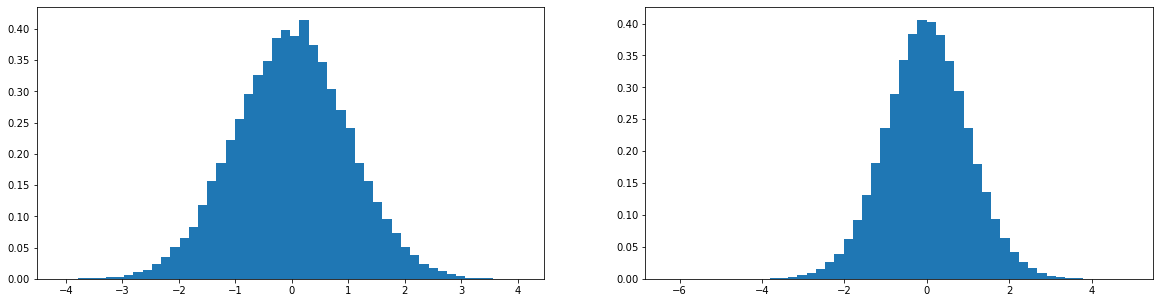

In [156]:
### Example for finding the initial scales for optimizing, 
# essentially the 0.1 and 0.2 in code above
x = torch.randn(1000,30)
w = torch.randn(30, 200) / 30 ** 0.5 ##The fan_in, important for initilization
# Recall , this is for TanH only, for example Relu is (2/n) ** 0.5
#Square root of the connecting dimension, 
# goal is to get standard deviation of 1
y = x @ w
print(x.mean(),x.std()) 
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density=True)

In [160]:
#Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #Forward pass
    emb = C[Xb] #Embed characets into the vectors
    embcat = emb.view(emb.shape[0], -1) #Concatenate the vectors        
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation, 
    # standardized the gaussian, insight from Paper
    # Batch norm layer
    #---------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # After we calibrate the batch norm and have trackers
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-linearity
    #---------------------------------------------------
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #Update
    lr = 0.1 if i < 100000 else 0.01 # Steep learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #Track Stats
    if i % 10000 == 0: #  Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

    #Implement Batch Intilization because two problems
    # 1 - Too small TanH does nothing
    # 2 - Too large Tanh is saturated, look at image below
    # now every Nueron will guassianed, but don't want it to be so 
    # at every  neuron, only at initialization 
    # So, we have to Scale And Gain, 
    # scaling by gain and offsetting by some bias


In [144]:
hpreact.shape
#32,200 and we want these to roughly gaussian

torch.Size([32, 200])

In [145]:
hpreact.mean(0, keepdim=True).shape


torch.Size([1, 200])

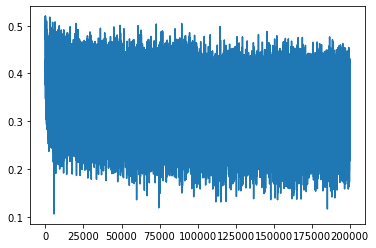

In [146]:
plt.plot(lossi)
# no longer had hocket stick look, weights have been shrunk down 
# so we can see if the loss is on the right path

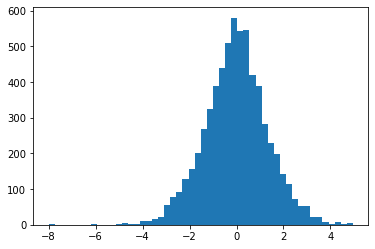

In [147]:
plt.hist(hpreact.view(-1).tolist(),50);
#Preactivation range from (-30,30) to (-4,4)
# After intilization fix

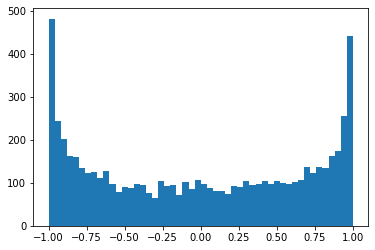

In [148]:
plt.hist(h.view(-1).tolist(),50);

In [151]:
@torch.no_grad() #This decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #Concatenate into (N,block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation, 
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # instead of doing it dynamically, as in above, we do using the function from above
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    # Advatange is that we can do single examples since means and stds are fixed 
    # Padding out and adding in entropy(regularizer), like augmenting to reduce overfit


    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# Improvements to loss after changes baised on notes from below 
# we had smaller weights and biases for 1st neuron
# Reason fro change was tanh layer was too saturated, 
# shown previously by lot of white space in figure below



train 2.062958240509033
val 2.117814302444458


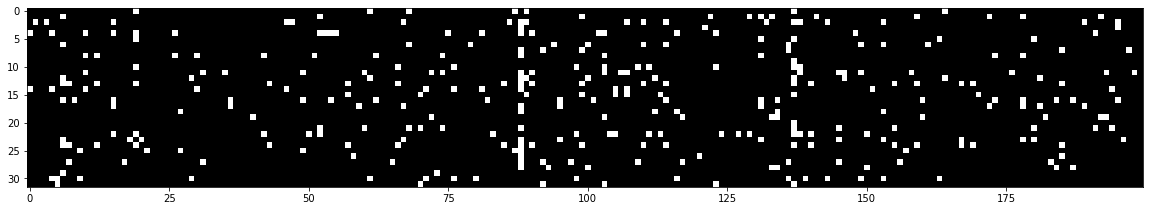

In [152]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest') #Boolean tensor
#Shows how often in a flat region, 
# white if true and black if not
# from 30 examples with 200 neurons

#Lot of white space in first run, so the tanh function was very active
# if mainly black spots, dead neuron

# Same methodoloy for other activation function like
# 1 - Sigmoid
# 2 - Tanh
# 3 - ReLU
# 4 - Leaky ReLU
# 5 - Maxout
# 6 - ELU

# Conclusion, not optimal and need to fix initialization because 
# there are too many extermes in the data, as shown by 2 graphs above

# Initlization fixed , less white 